### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import seaborn as sns
import subjects

# from neuropy.analyses import detect_local_sleep_epochs

In [ ]:
sessions = subjects.mua_sess()

off_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zt = np.array([0, 4])
    period = zt * 3600 + post[0]

    for i, t in enumerate(period):
        off_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"Zt{zt[i]}-{zt[i]+1}",
                    "off_duration": [sess.off.time_slice(t, t + 3600).durations.sum()],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

off_duration = pd.concat(off_duration, ignore_index=True)
subjects.GroupData().save(off_duration, "off_total_duration")

In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

# plt.figure(figsize=(8,11))
fig = plotting.Fig(grid=(4, 3),fontsize=12)

for i, grp in enumerate(["SD"]):
    data = off_duration[off_duration["grp"] == grp]
    ax = plt.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="off_duration",
        hue="sub",
        marker="o",
        palette=["#f94848"] * 7,
        ax=ax,
        legend=None,
    )
    ax.set_xlim([-1,2])

ax.set_xlabel('Zt time (h)')
ax.set_ylabel('Time in off (s)')
ax.set_title('OFF periods during\nsleep deprivation')
# ax.set_ylim([30,450])



### Off periods vs rpls/pbe CCG (Like paper EDF 2H but in 0.5 hour blocks at the beginning of POST and right before/after SD end)
- In the hippocampus following PBE/SWR there is a brief period of silence. When plotting the ccg between ripple-stops and off-starts, we see a clear peak around zero. This suggests, off periods detected include post-SWR silence periods too, making it hard to interpret sleep deprivation-induced off-periods in the hippocampus (unlike what was observed in the cortex in Vyazovskiy et al. 2011).
- One possible way to analayze this can be assessing mua activity within these off-periods and see if later in sleep deprivation if neurons more or less silent compared to earlier in sleep deprivation.

First write a function to grab the appropriate times.

In [29]:
from copy import deepcopy
from neuropy.core import Epoch
def get_30min_zt(zt_1h_in):
    starts, stops, labels = [], [], []
    for block, new_block, start_off, stop_off in zip(["0-1", "4-5", "5-6"], ["0-0.5", "4.5-5", "5-5.5"], [1800, 1800, 0], [0, 0, -1800]):
        block_use = deepcopy(zt_1h_in)[block]
        starts.append(block_use.starts[0] + start_off)
        stops.append(block_use.stops[0] + stop_off)
        labels.append(new_block)

    return Epoch(pd.DataFrame({"start": starts, "stop": stops, "label": labels}))

sess = subjects.mua_sess()[0]
print(sess.get_zt_1h().to_dataframe())
get_30min_zt(sess.get_zt_1h())

   start   stop label  duration
0   2146  11146   PRE      9000
1  11166  15006  MAZE      3840
2  15090  18690   0-1      3600
3  18690  22290   1-2      3600
4  22290  25890   2-3      3600
5  25890  29490   3-4      3600
6  29490  33090   4-5      3600
7  33090  36690   5-6      3600


3 epochs
Snippet: 
    start   stop  label
0  16890  18690  0-0.5
1  31290  33090  4.5-5
2  33090  34890  5-5.5

In [46]:
# code to check below!
zt2 = get_30min_zt(sess.get_zt_1h())
# e = zt2.to_dataframe().iloc[0]
# period = period = [e.start, e.stop]
# sess.off_epochs.time_slice(*period).starts

In [44]:
from neuropy.utils.ccg import correlograms

sessions = subjects.mua_sess()
ccg_df = []
for sub, sess in enumerate(sessions):
    zt_epochs = get_30min_zt(sess.get_zt_1h())
    # zt_epochs = sess.get_zt_epochs()[2:]

    for e in zt_epochs.itertuples():
        period = [e.start, e.stop]
        # Original BG code - seems to be counting ALL delta wave in demoninator
        # off_starts = sess.off_epochs.starts
        # off_stops = sess.off_epochs.stops
        off_starts = sess.off_epochs.time_slice(*period).starts
        off_stops = sess.off_epochs.time_slice(*period).stops
        ndelta = sess.off_epochs.time_slice(*period).n_epochs

        # NRK check code
        # off_starts_nk = sess.off_epochs.time_slice(*period).starts
        # off_stops_nk = sess.off_epochs.time_slice(*period).stops
        
        rpls = sess.ripple.time_slice(*period)
        rpls_t = rpls.to_dataframe().peak_time
        nrip = rpls.n_epochs

        times = np.concatenate([off_starts, off_stops, rpls_t])
        ids = np.concatenate(
            [
                1 * np.ones_like(off_starts),
                2 * np.ones_like(off_stops),
                3 * np.ones_like(rpls_t),
            ]
        )
        sort_ind = np.argsort(times)

        ccg = correlograms(
            times[sort_ind],
            ids[sort_ind].astype("int"),
            sample_rate=1250,
            bin_size=0.001,
            window_size=0.5,
        )

        # NRK code check
        # times_nk = np.concatenate([off_starts_nk, off_stops_nk, rpls_t])
        # ids_nk = np.concatenate(
        #     [
        #         1 * np.ones_like(off_starts_nk),
        #         2 * np.ones_like(off_stops_nk),
        #         3 * np.ones_like(rpls_t),
        #     ]
        # )
        # sort_ind_nk = np.argsort(times_nk)

        # ccg_nk = correlograms(
        #     times_nk[sort_ind_nk],
        #     ids_nk[sort_ind_nk].astype("int"),
        #     sample_rate=1250,
        #     bin_size=0.001,
        #     window_size=0.5,
        # )
        
        ccg_df.append(
            pd.DataFrame(
                {
                    # "ccg_from_start": ccg[0, 2, :] / len(off_starts), # original code divided by total # delta wave across the whole session!
                    # "ccg_from_stop": ccg[1, 2, :] / len(off_stops),
                    "ccg_from_start": ccg[0, 2, :] / ndelta, # new code divides by total # delta wave in each epoch
                    "ccg_from_stop": ccg[1, 2, :] / ndelta,
                    "time": np.linspace(-0.25, 0.25, 501),
                    "zt": e.label,
                    "session": sub,
                    "grp": sess.tag,
                    "nripple_from_start": ccg[0, 2, :],
                    "nripple_from_stop": ccg[1, 2, :],
                    "noffs": len(off_starts),
                    "poff_start|ripple": ccg[2, 0, :] / nrip,
                    "poff_stop|ripple": ccg[2, 1, :] / nrip,
                    "noff_start_from_ripple": ccg[2, 0, :],
                    "noff_stop_from_ripple": ccg[2, 1, :],
                    "nripple": nrip,
                }
            ),
        )


ccg_df = pd.concat(ccg_df, ignore_index=True)
ccg_df

,ccg_from_start,ccg_from_stop,time,zt,session,grp,nripple_from_start,nripple_from_stop,noffs,poff_start|ripple,poff_stop|ripple,noff_start_from_ripple,noff_stop_from_ripple,nripple
0,0.000000,0.001912,-0.250,0-0.5,0,NSD,0,2,1046,0.000000,0.000879,0,1,1138
1,0.000956,0.000956,-0.249,0-0.5,0,NSD,1,1,1046,0.000000,0.000879,0,1,1138
2,0.000956,0.000956,-0.248,0-0.5,0,NSD,1,1,1046,0.000000,0.000000,0,0,1138
3,0.001912,0.000956,-0.247,0-0.5,0,NSD,2,1,1046,0.000000,0.000000,0,0,1138
4,0.000000,0.000956,-0.246,0-0.5,0,NSD,0,1,1046,0.000000,0.000879,0,1,1138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24043,0.000000,0.000000,0.246,5-5.5,15,SD,0,0,984,0.000000,0.000000,0,0,936
24044,0.001016,0.001016,0.247,5-5.5,15,SD,1,1,984,0.000000,0.001068,0,1,936
24045,0.000000,0.000000,0.248,5-5.5,15,SD,0,0,984,0.004274,0.000000,4,0,936
24046,0.000000,0.001016,0.249,5-5.5,15,SD,0,1,984,0.000000,0.000000,0,0,936


In [48]:
mean_prob

,time,ccg_from_start,ccg_from_stop,session,nripple_from_start,nripple_from_stop,noffs,poff_start|ripple,poff_stop|ripple,noff_start_from_ripple,noff_stop_from_ripple,nripple


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

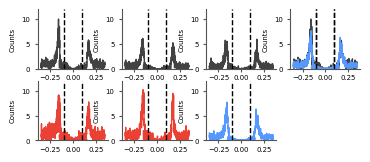

In [49]:
# This plot is overly busy and less interpretable - same numbers than actual figure, just different normalization
import seaborn as sns

fig = subjects.SdFig().fig1_supp(12)

grps_list, zt_list, start_peak, stop_peak, nsesh = [], [], [], [], []
for g, grp in enumerate(["NSD", "SD"]):
    grp_df = ccg_df[ccg_df.grp == grp]
    for z, zt in enumerate(["0-0.5", "4.5-5", "5-5.5"]):
        z_df = grp_df[grp_df.zt == zt].copy()
        ax = plt.subplot(fig.gs[g, z])
        mean_prob = z_df.groupby("time").mean(numeric_only=True).reset_index()

        grps_list.append(grp)
        zt_list.append(zt)
        nsesh.append(len(z_df.session.unique()))
        for c, col in enumerate(["ccg_from_start", "ccg_from_stop"]):
            time = mean_prob["time"].values
            if c == 0:
                time = time - 0.1
                start_peak.append(mean_prob[col].values.max())
            if c == 1:
                time = time + 0.1
                stop_peak.append(mean_prob[col].values.max())

            if grp == "NSD":
                color = subjects.colors_sd(1)[0]
            elif grp == "SD":
                color = subjects.colors_sd(1)[1] if zt in ["0-0.5", "4.5-5"] else subjects.colors_rs(1)[0]
            ax.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
            # ax.plot(time, mean_prob[col].values, lw=1, color=color)
            # ax.set_xlim([-0.03,0.03])
            ax.set_ylim([0, 12])
            ax.ticklabel_format(axis="y", style="scientific")
            # ax.set_title("End of Off period vs Ripples")
            # ax.set_xlabel("Time from start of ripple (ms)")
            ax.set_ylabel("Counts")

        ax.axvline(0.1, ls="--", color="k", lw=1)
        ax.axvline(-0.1, ls="--", color="k", lw=1)

# Plot NSD NS1 versus SD RS1
axbw = plt.subplot(fig.gs[0, 3])
ns1_df = ccg_df[(ccg_df.grp == "NSD") & (ccg_df.zt == "0-0.5")]
rs_df = ccg_df[(ccg_df.grp == "SD") & (ccg_df.zt == "5-5.5")]

for df_use, color in zip([ns1_df, rs_df], [subjects.colors_sd(1)[0], subjects.colors_rs(1)[0]]):
    mean_prob = df_use.groupby("time").mean(numeric_only=True).reset_index()
    for c, col in enumerate(["ccg_from_start", "ccg_from_stop"]):
        time = mean_prob["time"].values
        if c == 0:
            time = time - 0.1
            start_peak.append(mean_prob[col].values.max())
        if c == 1:
            time = time + 0.1
            stop_peak.append(mean_prob[col].values.max())

        # if grp == "NSD":
        #     color = subjects.colors_sd(1)[0]
        # elif grp == "SD":
        #     color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
        axbw.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
        # ax.set_xlim([-0.03,0.03])
        axbw.set_ylim([0, 12])
        axbw.ticklabel_format(axis="y", style="scientific")
        # ax.set_title("End of Off period vs Ripples")
        # ax.set_xlabel("Time from start of ripple (ms)")
        axbw.set_ylabel("Counts")

    axbw.axvline(0.1, ls="--", color="k", lw=1)
    axbw.axvline(-0.1, ls="--", color="k", lw=1)
    

fig.savefig(subjects.figpath_sd / "off_ripple_coupling", format="svg")

# peak_df = pd.DataFrame({"grp": grps_list, "zt": zt_list, "start_peak": start_peak, "stop_peak": stop_peak, "nsessions": nsesh})

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

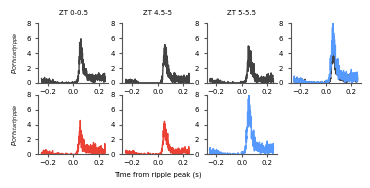

In [58]:
# Plot ripple -> OFF start probability - THIS is the plot used -see bottom for stats
import seaborn as sns

fig = subjects.SdFig().fig1_supp(12)

grps_list, zt_list, poff_peak, nsesh = [], [], [], []
for g, grp in enumerate(["NSD", "SD"]):
    grp_df = ccg_df[ccg_df.grp == grp]
    for z, zt in enumerate(["0-0.5", "4.5-5", "5-5.5"]):
        z_df = grp_df[grp_df.zt == zt].copy()
        ax = plt.subplot(fig.gs[g, z])
        mean_prob = z_df.groupby("time").mean(numeric_only=True).reset_index()

        grps_list.append(grp)
        zt_list.append(zt)
        nsesh.append(len(z_df.session.unique()))
        for c, col in enumerate(["poff_start|ripple"]):
            time = mean_prob["time"].values
            poff_peak.append(mean_prob[col].values.max())

            if grp == "NSD":
                color = subjects.colors_sd(1)[0]
            elif grp == "SD":
                color = subjects.colors_sd(1)[1] if zt in ["0-0.5", "4.5-5"] else subjects.colors_rs(1)[0]
            ax.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
            # ax.plot(time, mean_prob[col].values, lw=1, color=color)
            # ax.set_xlim([-0.03,0.03])
            ax.set_ylim([0, 8])
            ax.ticklabel_format(axis="y", style="scientific")
            # ax.set_title("End of Off period vs Ripples")
            # ax.set_xlabel("Time from start of ripple (ms)")
            if (z == 0):
                ax.set_ylabel("$p_{OFFstart|ripple}$")
            else:
                ax.set_ylabel("")
            if (z == 1) & (g == 1):
                ax.set_xlabel('Time from ripple peak (s)')
            if g == 0:
                ax.set_title(f"ZT {zt}")


# Plot NSD NS1 versus SD RS1
axbw = plt.subplot(fig.gs[0, 3])
ns1_df = ccg_df[(ccg_df.grp == "NSD") & (ccg_df.zt == "0-0.5")]
rs_df = ccg_df[(ccg_df.grp == "SD") & (ccg_df.zt == "5-5.5")]

for df_use, color in zip([ns1_df, rs_df], [subjects.colors_sd(1)[0], subjects.colors_rs(1)[0]]):
    mean_prob = df_use.groupby("time").mean(numeric_only=True).reset_index()
    for c, col in enumerate(["poff_start|ripple"]):
        time = mean_prob["time"].values
        poff_peak.append(mean_prob[col].values.max())

        # if grp == "NSD":
        #     color = subjects.colors_sd(1)[0]
        # elif grp == "SD":
        #     color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
        axbw.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
        # ax.set_xlim([-0.03,0.03])
        axbw.set_ylim([0, 8])
        axbw.ticklabel_format(axis="y", style="scientific")
        # ax.set_title("End of Off period vs Ripples")
        # ax.set_xlabel("Time from start of ripple (ms)")
        # axbw.set_ylabel("Counts")

fig.savefig(subjects.figpath_sd / "ripple_then_off_start_prob_30min_blocks", format="svg")
fig.savefig(subjects.figpath_sd / "ripple_then_off_start_prob_30min_blocks", format="pdf")

ValueError: zero-size array to reduction operation maximum which has no identity

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

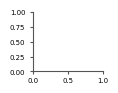

In [57]:
# Plot ripple -> OFF stop probability - Not shown
import seaborn as sns

fig = subjects.SdFig().fig1_supp(12)

grps_list, zt_list, poff_peak, nsesh = [], [], [], []
for g, grp in enumerate(["NSD", "SD"]):
    grp_df = ccg_df[ccg_df.grp == grp]
    for z, zt in enumerate(["0-2.5", "2.5-5", "5-7.5"]):
        z_df = grp_df[grp_df.zt == zt].copy()
        ax = plt.subplot(fig.gs[g, z])
        mean_prob = z_df.groupby("time").mean(numeric_only=True).reset_index()

        grps_list.append(grp)
        zt_list.append(zt)
        nsesh.append(len(z_df.session.unique()))
        for c, col in enumerate(["poff_stop|ripple"]):
            time = mean_prob["time"].values
            poff_peak.append(mean_prob[col].values.max())

            if grp == "NSD":
                color = subjects.colors_sd(1)[0]
            elif grp == "SD":
                color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
            ax.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
            # ax.plot(time, mean_prob[col].values, lw=1, color=color)
            # ax.set_xlim([-0.03,0.03])
            ax.set_ylim([0, 8])
            ax.ticklabel_format(axis="y", style="scientific")
            # ax.set_title("End of Off period vs Ripples")
            # ax.set_xlabel("Time from start of ripple (ms)")
            if (z == 0):
                ax.set_ylabel("$p_{OFFstop|ripple}$")
            else:
                ax.set_ylabel("")
            if (z == 1) & (g == 1):
                ax.set_xlabel('Time from ripple peak (s)')
            if g == 0:
                ax.set_title(f"ZT {zt}")



# Plot NSD NS1 versus SD RS1
axbw = plt.subplot(fig.gs[0, 3])
ns1_df = ccg_df[(ccg_df.grp == "NSD") & (ccg_df.zt == "0-2.5")]
rs_df = ccg_df[(ccg_df.grp == "SD") & (ccg_df.zt == "5-7.5")]

for df_use, color in zip([ns1_df, rs_df], [subjects.colors_sd(1)[0], subjects.colors_rs(1)[0]]):
    mean_prob = df_use.groupby("time").mean(numeric_only=True).reset_index()
    for c, col in enumerate(["poff_stop|ripple"]):
        time = mean_prob["time"].values
        poff_peak.append(mean_prob[col].values.max())

        # if grp == "NSD":
        #     color = subjects.colors_sd(1)[0]
        # elif grp == "SD":
        #     color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
        axbw.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
        # ax.set_xlim([-0.03,0.03])
        axbw.set_ylim([0, 8])
        axbw.ticklabel_format(axis="y", style="scientific")
        # ax.set_title("End of Off period vs Ripples")
        # ax.set_xlabel("Time from start of ripple (ms)")
        # axbw.set_ylabel("Counts")

fig.savefig(subjects.figpath_sd / "ripple_then_off_stop_prob", format="svg")
# fig.savefig(subjects.figpath_sd / "ripple_then_off_stop_prob", format="pdf")

#### Run Chi-squared 2x2 contingency test for plots above

In [51]:
# Create dfs with counts of total nripples and total noff periods for each group and epoch

ccg_max = ccg_df.groupby(["grp", "zt", "session"]).max().reset_index()
ccg_max_mean = ccg_max.groupby(["grp", "zt"]).mean().reset_index()  # For rough sanity checks
ccg_max_sum = ccg_max.groupby(["grp", "zt"]).sum().reset_index()

ccg_max_sum

,grp,zt,session,ccg_from_start,ccg_from_stop,time,nripple_from_start,nripple_from_stop,noffs,poff_start|ripple,poff_stop|ripple,noff_start_from_ripple,noff_stop_from_ripple,nripple
0,NSD,0-0.5,28,0.098778,0.080166,2.0,67,59,6043,0.062475,0.055076,67,59,8462
1,NSD,4.5-5,28,0.083100,0.083990,2.0,51,49,4783,0.065994,0.063374,51,49,6146
2,NSD,5-5.5,28,0.093767,0.066845,2.0,57,44,4928,0.074039,0.055853,57,44,5994
3,SD,0-0.5,92,0.142184,0.108042,2.0,48,36,2827,0.054694,0.041944,48,36,7703
4,SD,4.5-5,92,0.165416,0.131535,2.0,69,54,3653,0.066858,0.052536,69,54,8195
5,SD,5-5.5,92,0.090741,0.079249,2.0,84,75,7581,0.091318,0.082453,84,75,7521


In [52]:
# Get n values for each
ccg_max.groupby(["grp"]).sum(numeric_only=True)

,session,ccg_from_start,ccg_from_stop,time,nripple_from_start,nripple_from_stop,noffs,poff_start|ripple,poff_stop|ripple,noff_start_from_ripple,noff_stop_from_ripple,nripple
grp,,,,,,,,,,,,
NSD,84,0.275645,0.231000,6.0,175,152,15754,0.202508,0.174302,175,152,20602
SD,276,0.398341,0.318825,6.0,201,165,14061,0.212870,0.176932,201,165,23419


In [54]:
def chi2_nripple(ccg_max_df, zt1in, grp1in, point1in, zt2in, grp2in, point2in, test="pripple|off"):
    """Perform scipy.stats.chi2_contingency on nripples before/after an off period between two time points.
    Same if test="poff|ripple but for noff periods following a ripple."""
    ccg_df1 = ccg_max_df[(ccg_max_df.zt == zt1in) & (ccg_max_df.grp == grp1in)]
    ccg_df2 = ccg_max_df[(ccg_max_df.zt == zt2in) & (ccg_max_df.grp == grp2in)]
    assert test in ["pripple|off", "poff|ripple"]
    if test == 'pripple|off':
        table = np.array([[ccg_df1[f"nripple_from_{point1in}"].values[0], ccg_df2[f"nripple_from_{point2in}"].values[0]],
                          [ccg_df1.noffs.values[0], ccg_df2.noffs.values[0]]])
    else:
        table = np.array([[ccg_df1[f"noff_{point1in}_from_ripple"].values[0], ccg_df2[f"noff_{point2in}_from_ripple"].values[0]],
                          [ccg_df1.nripple.values[0], ccg_df2.nripple.values[0]]])
    res = stats.chi2_contingency(table)
    return res, table
grp1, grp2 = "NSD", "NSD"
zt1, zt2 = "5-5.5", "5-5.5"
point1, point2 = "start", "stop"
chi2_nripple(ccg_max_sum, zt1, grp1, point1, zt2, grp2, point2)

(Chi2ContingencyResult(statistic=1.4088734530714526, pvalue=0.23524349647057846, dof=1, expected_freq=array([[  50.56593351,   50.43406649],
        [4934.43406649, 4921.56593351]])),
 array([[  57,   44],
        [4928, 4928]]))

In [55]:
# Code check for above
grp1, grp2 = "NSD", "NSD"
zt1, zt2 = "5-5.5", "5-5.5"
point1, point2 = "start", "stop"

ccg_df1 = ccg_max_sum[(ccg_max_sum.zt == zt1) & (ccg_max_sum.grp == grp1)]
ccg_df2 = ccg_max_sum[(ccg_max_sum.zt == zt2) & (ccg_max_sum.grp == grp2)]
ccg_df2
table = np.array([[ccg_df1[f"nripple_from_{point1}"].values[0], ccg_df2[f"nripple_from_{point2}"].values[0]],
                  [ccg_df1.noffs.values[0], ccg_df2.noffs.values[0]]])
table
res = stats.chi2_contingency(table)
res

Chi2ContingencyResult(statistic=1.4088734530714526, pvalue=0.23524349647057846, dof=1, expected_freq=array([[  50.56593351,   50.43406649],
       [4934.43406649, 4921.56593351]]))

#### **NOT USED:** First check pripple|off

In [9]:
# Loop through each comparison and perform 2x2 chi-square test - for pripple | off
grp1, grp2 = "NSD", "NSD"
zt1, zt2 = "5-7.5", "5-7.5"
point1, point2 = "start", "stop"

grp1_list, grp2_list = [], []
zt1_list, zt2_list = [], []
point1_list, point2_list = [], []
stat_list = []

# 1) ripple prob lower after than before off period
pval_list, grp_list, zt_list, prob_list, pt_list = [], [], [], [], []
for grp in ["NSD", "SD"]:
    for zt in ["0-2.5", "2.5-5", "5-7.5"]:
        point1, point2 = "start", "stop"
        res, table = chi2_nripple(ccg_max_sum, zt, grp, point1, zt, grp, point2)
        pval_list.append(res.pvalue)
        grp_list.append(grp)
        zt_list.append(zt)
        pt_list.append([point1, point2])
        stat_list.append(res.statistic)
        prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
    prob_array = np.array(prob_list)
    pt_array = np.array(pt_list)
df1 = pd.DataFrame({"grp1": grp_list, "zt1": zt_list, "point1": pt_array[:, 0], 
                    "grp2": grp_list, "zt2": zt_list, "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1]})

# Comparisons to do: 1) As above but only for 0-2.5
pval_list, grp1_list, grp2_list, zt_list, prob_list, pt_list, stat_list = [], [], [], [], [], [], []
grp1, grp2 = "NSD", "SD"
for zt in ["0-2.5", "2.5-5"]:
    point1, point2 = "start", "stop"
    res, table = chi2_nripple(ccg_max_sum, zt, grp, point1, zt, grp, point2)
    pval_list.append(res.pvalue)
    grp1_list.append("NSD")
    grp2_list.append("SD")
    zt_list.append(zt)
    pt_list.append([point1, point2])
    prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
    stat_list.append(res.statistic)
prob_array = np.array(prob_list)
pt_array = np.array(pt_list)
df1a = pd.DataFrame({"grp1": grp1_list, "zt1": zt_list, "point1": pt_array[:, 0], 
                    "grp2": grp2_list, "zt2": zt_list, "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1]})


# 2) Start count for each group from 0-2.5 vs 2.5-5 and 2.5-5 vs 5-7.5
pval_list, grp_list, zt_list, prob_list, pt_list, stat_list = [], [], [], [], [], []
for grp in ["NSD", "SD"]:
    for zt1, zt2 in zip(["0-2.5", "2.5-5", "0-2.5"], ["2.5-5", "5-7.5", "5-7.5"]):
        point1, point2 = "start", "start"
        res, table = chi2_nripple(ccg_max_sum, zt1, grp, point1, zt2, grp, point2)
        pval_list.append(res.pvalue)
        grp_list.append(grp)
        zt_list.append([zt1, zt2])
        pt_list.append([point1, point2])
        prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
        stat_list.append(res.statistic)
    zt_array = np.array(zt_list)
    prob_array = np.array(prob_list)
    pt_array = np.array(pt_list)
df2 = pd.DataFrame({"grp1": grp_list, "zt1": zt_array[:, 0], "point1": pt_array[:, 0], 
                    "grp2": grp_list, "zt2": zt_array[:, 1], "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1]})
# 3) RS start vs NS1 start
res, table = chi2_nripple(ccg_max_sum, "0-2.5", "NSD", "start", "5-7.5", "SD", "start")
prob = table[0]/table[1]

off_rip_chi2_df = pd.concat((df1, df1a, df2)).reset_index().drop(columns="index")

off_rip_chi2_df.loc[off_rip_chi2_df.shape[0]] = ["NSD", "0-2.5", "start", "SD", "5-7.5", "start",
                                                 res.pvalue, res.statistic, prob[0], prob[1]]
off_rip_chi2_df.to_csv(subjects.figpath_sd / "off_ripple_coupling_stats.csv")
off_rip_chi2_df


,grp1,zt1,point1,grp2,zt2,point2,pvalue,test_stat,prip1,prip2
0,NSD,0-2.5,start,NSD,0-2.5,stop,2.523526e-02,5.007670,0.007726,0.006257
1,NSD,2.5-5,start,NSD,2.5-5,stop,6.964907e-03,7.281997,0.006943,0.005199
2,NSD,5-7.5,start,NSD,5-7.5,stop,2.435254e-02,5.069348,0.007062,0.005351
3,SD,0-2.5,start,SD,0-2.5,stop,4.291061e-02,4.098920,0.010761,0.008486
4,SD,2.5-5,start,SD,2.5-5,stop,3.097601e-03,8.749070,0.012226,0.009039
5,SD,5-7.5,start,SD,5-7.5,stop,8.293785e-04,11.174307,0.007043,0.005163
6,NSD,0-2.5,start,SD,0-2.5,stop,4.291061e-02,4.098920,0.010761,0.008486
7,NSD,2.5-5,start,SD,2.5-5,stop,3.097601e-03,8.749070,0.012226,0.009039
8,NSD,0-2.5,start,NSD,2.5-5,start,2.687824e-01,1.222950,0.007726,0.006943
9,NSD,2.5-5,start,NSD,5-7.5,start,9.136236e-01,0.011766,0.006943,0.007062


# EDF2H stats **USED** in figure: poff|ripple

In [56]:
# Loop through each comparison and perform 2x2 chi-square test - for poff | ripple
grp1, grp2 = "NSD", "NSD"
zt1, zt2 = "5-5.5", "5-5.5"
point1, point2 = "start", "stop"

grp1_list, grp2_list = [], []
zt1_list, zt2_list = [], []
point1_list, point2_list = [], []
stat_list = []

# # 1) ripple prob lower after than before off period
# pval_list, grp_list, zt_list, prob_list, pt_list = [], [], [], [], []
# for grp in ["NSD", "SD"]:
#     for zt in ["0-2.5", "2.5-5", "5-7.5"]:
#         point1, point2 = "start", "stop"
#         res, table = chi2_nripple(ccg_max_sum, zt, grp, point1, zt, grp, point2, test="poff|ripple")
#         pval_list.append(res.pvalue)
#         grp_list.append(grp)
#         zt_list.append(zt)
#         pt_list.append([point1, point2])
#         stat_list.append(res.statistic)
#         prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
#     prob_array = np.array(prob_list)
#     pt_array = np.array(pt_list)
# df1 = pd.DataFrame({"grp1": grp_list, "zt1": zt_list, "point1": pt_array[:, 0], 
#                     "grp2": grp_list, "zt2": zt_list, "point2": pt_array[:, 1],
#                     "pvalue": pval_list, "test_stat": stat_list,
#                     "prip1": prob_array[:, 0], "prip2": prob_array[:, 1]})

# # Comparisons to do: 1) As above but only for 0-2.5
pval_list, grp1_list, grp2_list, zt_list, prob_list, pt_list, stat_list, phi_list = [], [], [], [], [], [], [], []
grp1, grp2 = "NSD", "SD"
for zt in ["0-0.5", "4.5-5", "5-5.5"]:
    point1, point2 = "start", "start"
    res, table = chi2_nripple(ccg_max_sum, zt, grp1, point1, zt, grp2, point2, test="poff|ripple")
    phi_list.append(np.sqrt(res.statistic / np.sum(table.reshape(-1)) / res.dof))  # calculate effect size
    pval_list.append(res.pvalue)
    grp1_list.append("NSD")
    grp2_list.append("SD")
    zt_list.append(zt)
    pt_list.append([point1, point2])
    prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
    stat_list.append(res.statistic)
prob_array = np.array(prob_list)
pt_array = np.array(pt_list)
df1a = pd.DataFrame({"grp1": grp1_list, "zt1": zt_list, "point1": pt_array[:, 0], 
                    "grp2": grp2_list, "zt2": zt_list, "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1],
                    "phi": phi_list})


# 2) Start count for each group from 0-2.5 vs 2.5-5 and 2.5-5 vs 5-7.5
pval_list, grp_list, zt_list, prob_list, pt_list, stat_list, phi_list = [], [], [], [], [], [], []
for grp in ["NSD", "SD"]:
    for zt1, zt2 in zip(["0-0.5", "4.5-5", "0-0.5"], ["4.5-5", "5-5.5", "5-5.5"]):
        for point in ["start"]:
            # point1, point2 = "start", "start"
            point1, point2 = point, point
            
            res, table = chi2_nripple(ccg_max_sum, zt1, grp, point1, zt2, grp, point2, test="poff|ripple")
            phi_list.append(np.sqrt(res.statistic / np.sum(table.reshape(-1)) / res.dof))  # calculate effect size
            pval_list.append(res.pvalue)
            grp_list.append(grp)
            zt_list.append([zt1, zt2])
            pt_list.append([point1, point2])
            prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
            stat_list.append(res.statistic)
    zt_array = np.array(zt_list)
    prob_array = np.array(prob_list)
    pt_array = np.array(pt_list)
df2 = pd.DataFrame({"grp1": grp_list, "zt1": zt_array[:, 0], "point1": pt_array[:, 0], 
                    "grp2": grp_list, "zt2": zt_array[:, 1], "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1],
                    "phi": phi_list})
# 3) RS start vs NS1 start
res, table = chi2_nripple(ccg_max_sum, "0-0.5", "NSD", "start", "5-5.5", "SD", "start", test="poff|ripple")
res2, table2 = chi2_nripple(ccg_max_sum, "0-0.5", "NSD", "stop", "5-5.5", "SD", "stop", test="poff|ripple")
prob = table[0]/table[1]
prob2 = table2[0]/table2[1]
phi = np.sqrt(np.sqrt(res.statistic / np.sum(table.reshape(-1)) / res.dof))  # calculate effect size

rip_off_chi2_df = pd.concat((df1a, df2)).reset_index().drop(columns="index")

rip_off_chi2_df.loc[rip_off_chi2_df.shape[0]] = ["NSD", "0-0.5", "start", "SD", "5-5.5", "start",
                                                 res.pvalue, res.statistic, prob[0], prob[1], phi]
# rip_off_chi2_df.loc[rip_off_chi2_df.shape[0]] = ["NSD", "0-2.5", "stop", "SD", "5-7.5", "stop",
#                                                  res2.pvalue, res2.statistic, prob[0], prob[1]]
rip_off_chi2_df.to_csv(subjects.figpath_sd / "ripple_off_coupling_stats_30minblocks.csv")
rip_off_chi2_df


,grp1,zt1,point1,grp2,zt2,point2,pvalue,test_stat,prip1,prip2,phi
0,NSD,0-0.5,start,SD,0-0.5,start,0.241394,1.372437,0.007918,0.006231,0.009182
1,NSD,4.5-5,start,SD,4.5-5,start,1.000000,0.000000,0.008298,0.008420,0.000000
2,NSD,5-5.5,start,SD,5-5.5,start,0.396320,0.719464,0.009510,0.011169,0.007258
3,NSD,0-0.5,start,NSD,4.5-5,start,0.874564,0.024921,0.007918,0.008298,0.001301
4,NSD,4.5-5,start,NSD,5-5.5,start,0.543365,0.369340,0.008298,0.009510,0.005491
5,NSD,0-0.5,start,NSD,5-5.5,start,0.356508,0.850156,0.007918,0.009510,0.007636
6,SD,0-0.5,start,SD,4.5-5,start,0.131347,2.276506,0.006231,0.008420,0.011923
7,SD,4.5-5,start,SD,5-5.5,start,0.097941,2.738753,0.008420,0.011169,0.013137
8,SD,0-0.5,start,SD,5-5.5,start,0.001528,10.045020,0.006231,0.011169,0.025576
9,NSD,0-0.5,start,SD,5-5.5,start,0.043531,4.074654,0.007918,0.011169,0.126063


In [37]:
zt = "0-2.5"
grp = "NSD"
df_use = ccg_max[(ccg_max.grp == grp) & (ccg_max.zt == zt)]
stats.ttest_rel(df_use.ccg_from_start, df_use.ccg_from_stop, alternative="greater")

TtestResult(statistic=2.2351203133667035, pvalue=0.030255984691231388, df=7)